In [1]:
# run this cell to generate data for the javascript simulator
using CSV, Plots, DataFrames

In [3]:
wb_pop = CSV.read("covid_data/wb_population.csv")
dfp = wb_pop[:,Symbol.(["Country Name", "2018"])]
rename!(dfp,Symbol.(["country"; "population"]))
size(dfp)

(264, 2)

In [4]:
confirmed_global = CSV.read("covid_data/time_series_covid19_confirmed_global.csv")
df = confirmed_global[ismissing.(confirmed_global[!,Symbol("Province/State")]),2:end]
sdf = df
df[:,:country] = df[:,Symbol("Country/Region")]
df = df[:,4:end]
df = hcat(df[:,:country],df[:,1:end-1])
rename!(df,Symbol.(["country"; ["$(i-1)" for i in 2:size(df)[2]]]))
size(df)

(181, 77)

In [5]:
dfc = join(df, dfp, kind = :inner, on = intersect(names(df), names(dfp)))
size(dfc)

(156, 78)

In [6]:
# rename!(df, Dict(:0 => :country))
CSV.write("../SIRjs/data_jhp_clean.csv",dfc)

"../SIRjs/data_jhp_clean.csv"

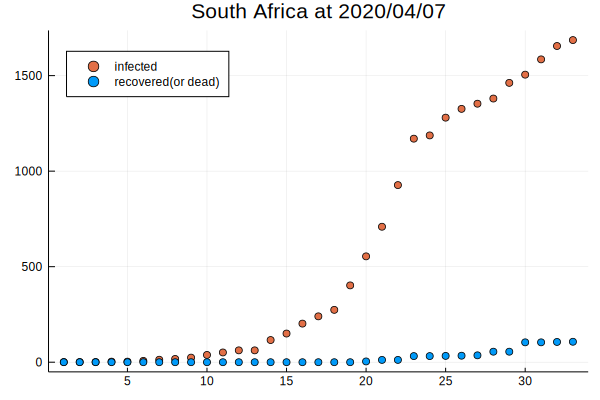

In [13]:
# Data from John Hopkins as of 2020/03/31
# https://github.com/CSSEGISandData/COVID-19
using CSV, Plots, DataFrames
country = "South Africa"
N = 60000000.0
date = "2020/04/07"
confirmed_global = CSV.read("covid_data/time_series_covid19_confirmed_global.csv")
confirmed = convert(Array,
    confirmed_global[(confirmed_global[!,Symbol("Country/Region")].==country) .&
        (ismissing.(confirmed_global[!,Symbol("Province/State")])),
        40:size(confirmed_global)[2]])[1,:]
deaths_global = CSV.read("covid_data/time_series_covid19_deaths_global.csv")
deaths = convert(Array,
    deaths_global[deaths_global[!,Symbol("Country/Region")].==country,
        40:size(deaths_global)[2]])[1,:]
recovered_global = CSV.read("covid_data/time_series_covid19_recovered_global.csv")
recovered = convert(Array,
    recovered_global[recovered_global[!,Symbol("Country/Region")].==country,
        40:size(recovered_global)[2]])[1,:]
removed = recovered+deaths
data = [confirmed removed]
data = data[data[:,1] .!= 0,:]   # get rid of leading zero data
data_labels=["infected" "recovered(or dead)"]
data_colors=[2 1]
plot_title="$country at $date"
scatter(data, legend=:topleft, label=data_labels,
color=data_colors,title=plot_title)

In [2]:
sir_app_data = data[:,1]
println(sir_app_data)

[1, 1, 1, 3, 3, 7, 13, 17, 24, 38, 51, 62, 62, 116, 150, 202, 240, 274, 402, 554, 709, 927, 1170, 1187, 1280, 1326, 1353, 1380, 1462, 1505, 1585, 1655, 1686]


In [3]:
function simulate(n,β,γ,N)
    sim = reshape(ones(n*4),(n,4))
    sim[1,:]=[(N-1)/N, 1/N, 0, 1/N]
    for k in 2:n
        s, i, r, c = sim[k-1,:]
        ns = s - β[k-1]*s*i
        ni = i + β[k-1]*s*i - γ[k-1]*i
        nr = r + γ[k-1]*i
        nc = c + β[k-1]*s*i
        sim[k,:] = [ns, ni, nr, nc]
    end
    sim
end

simulate (generic function with 1 method)

In [77]:
function expand_betas(betas,bps,n)
    β = ones(n)
    for k in length(bps):-1:1
        β[1:bps[k]]=betas[k]*ones(bps[k])
    end
    β
end

expand_betas (generic function with 1 method)

In [78]:
expand_betas([0.463 0.058],[22 31],31)

31-element Array{Float64,1}:
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 0.463
 ⋮    
 0.463
 0.463
 0.463
 0.058
 0.058
 0.058
 0.058
 0.058
 0.058
 0.058
 0.058
 0.058

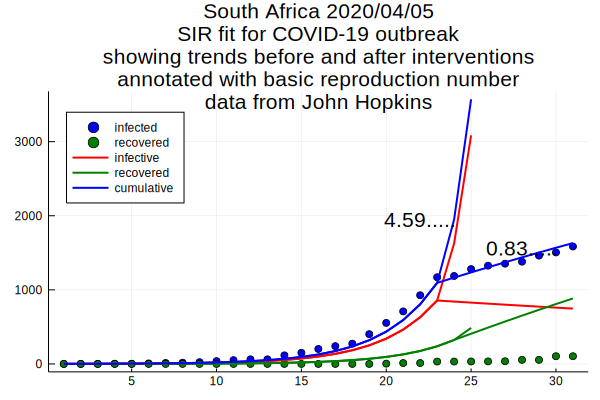

In [94]:
N=1000000
n=size(data)[1]
γ = 0.1*ones(n)
bps = [22 n]
β_opt = opt_betas # [0.463 0.058]
labels=["infected" "recovered"]
colors=[:blue :green]
ptl0 = " $country $date"
ptl1 = "SIR fit for COVID-19 outbreak"
ptl2 = " showing trends before and after interventions "
ptl3 = " annotated with basic reproduction number "
ptl4 = "data from John Hopkins"
plot_title= ptl0 * "\n" * ptl1 * "\n" * ptl2 * "\n" * ptl3 * "\n" * ptl4
fig = scatter(data,legend=:topleft,color=colors,label=labels,title=plot_title)
labels = [ "infective" "recovered" "cumulative"]
colors = [:red :green :blue]
β=expand_betas([β_opt[1]],[bps[1]],n)
r=round(β[1]/γ[1],digits=2)
sim = simulate(n,β,γ,N)
y = N.*sim[1:ld[1]+3,2:4]
plot!(y,color=colors,label=labels,linewidth=2,
    annotations = (size(y)[1]-1, y[size(y)[1]-1,3], Plots.text("$r"*".....", :right)))
for k in 2:length(ld)
    β = expand_betas([β_opt[j] for j in 1:k],[bps[j] for j in 1:k],n)
    # β[ld[k-1]+1:end]=ldb[k]*ones(n-ld[k-1])
    r=round(β[bp_opt[k]]/γ[bp_opt[k]],digits=2)
    sim = simulate(n,β,γ,N)
    m = min(bps[k]+3,n)
    y = N.*sim[1:m,2:4]
    plot!(y,color=colors,label=nothing,linewidth=2,
       annotations = (bps[k]-1, y[bps[k]-1,3], Plots.text("$r"*".....", :right)))
end
savefig(fig,"covid_plots/SIRfit$country")
fig

In [7]:
using QuadDIRECT

┌ Info: Precompiling QuadDIRECT [dae52e8d-d666-5120-a592-9e15c33b8d7a]
└ @ Base loading.jl:1242


In [86]:
n=size(data)[1]
initial_betas = [0.3 0.15]
breaks = [22 n]
lower, upper = zeros(length(breaks)), ones(length(breaks))
splits = ([0.25, 0.5, 0.75], [0.25, 0.5, 0.75]) 
loss = function(betas)
    β = expand_betas(betas,breaks,n)
    sum(abs2,(N*simulate(n,β,γ,N)[:,4]) .- (data[:,1]) ) 
end  
root, x0 = analyze(loss, splits, lower, upper)

(BoxRoot@[NaN, NaN], [0.5, 0.5])

In [87]:
box = minimum(root)
println(value(box))
opt_betas = position(box, x0)

88034.99438848541


2-element Array{Float64,1}:
 0.4593048751080281 
 0.08325950175975308

In [84]:
loss(opt_betas)

2.4784394842747606

In [85]:
loss([0.463 0.058])

3.311156615281239